# Predicting Kickstarter Campaign Success

![](../images/kickstarter.png)

## Overview

Using data webscraped from Kickstarter by WebRobots, we investigated what makes a Kickstarter project successful. We created classification models to predict the success or failure of 191,875 kickstarter projects launched between April 2009 and October 2020. Our final model was able to accurately predict success (a project is fully funded by backers) or failure of a project with 80% accuracy using only information that is would be available to creators at project launch.

## Business Problem

Projects on kickstarter have a funding goal, where backers pledge to fund the project only if the total funding is met.  If the amount pledged is less than the goal, the project does not get funded and it fails.  When a project is successfully funded, the backers are charged the amount they pledged and the project creator gets the funds to carry out their project, while Kickstarter gets a commission.  In this project, we will examine the success rate of campaigns from the perspective of Kickstarter in order to understand the most important factors for campaign success.  This will allow Kickstarter to aid creators in hitting funding goals and maximize rates of success.

## Imports

In [51]:
%load_ext autoreload
%autoreload 2
import sys
import os
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
import numpy as np
import pandas as pd
import json
from glob import glob
from datetime import datetime as dt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from src import datacleaning as dc
from src import modeling as md
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('max_columns', None)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Read in Data

The data is from https://webrobots.io, a webscraping bot that has kickstarter data from 2009 until 2020.  The most current dataset was downloaded. The unzipped data came as 60 csv files and was compiled into a dataframe with the function below.  

In [52]:
# df = pd.DataFrame()
# for f in glob('../data/Kickstarter*.csv'):
#     df = pd.concat([df, pd.read_csv(f)])
# df.to_csv('..data/Kickstarter_full.csv', index = False)

In [53]:
df = pd.read_csv('../data/Kickstarter_full.csv')

In [54]:
df.head()

,backers_count,blurb,category,converted_pledged_amount,country,country_displayable_name,created_at,creator,currency,currency_symbol,currency_trailing_code,current_currency,deadline,disable_communication,friends,fx_rate,goal,id,is_backing,is_starrable,is_starred,launched_at,location,name,permissions,photo,pledged,profile,slug,source_url,spotlight,staff_pick,state,state_changed_at,static_usd_rate,urls,usd_pledged,usd_type
0,2,I am building a website as a platform for stud...,"{""id"":362,""name"":""Makerspaces"",""slug"":""technol...",8,AU,Australia,1526014096,"{""id"":576665900,""name"":""Emma - Teaching Little...",AUD,$,True,USD,1528928562,False,NaN,0.713110,1000.0,2116213542,NaN,False,NaN,1526336562,"{""id"":1102170,""name"":""Geelong"",""slug"":""geelong...",STEAM Challenges for kids,NaN,"{""key"":""assets/021/192/015/169fac7e245d13c5b2c...",11.32,"{""id"":3378817,""project_id"":3378817,""state"":""in...",steam-challenges-for-kids,https://www.kickstarter.com/discover/categorie...,False,False,failed,1528928562,0.754091,"{""web"":{""project"":""https://www.kickstarter.com...",8.536309,domestic
1,43,"For my first solo museum exhibition, I'm const...","{""id"":288,""name"":""Installations"",""slug"":""art/i...",3390,US,the United States,1490746168,"{""id"":1570512397,""name"":""Mark Reamy"",""is_regis...",USD,$,True,USD,1493819063,False,NaN,1.000000,3000.0,162726099,NaN,False,NaN,1491227063,"{""id"":1123319,""name"":""Gwangju-Si"",""slug"":""gwan...",Moving Mountains - An Exhibition in South Korea,NaN,"{""key"":""assets/016/043/280/779386fd82d6830e626...",3390.00,"{""id"":2940021,""project_id"":2940021,""state"":""in...",moving-mountains-an-exhibition-in-south-korea,https://www.kickstarter.com/discover/categorie...,True,True,successful,1493819064,1.000000,"{""web"":{""project"":""https://www.kickstarter.com...",3390.000000,domestic
2,243,"Jenn lives in an underground bunker, protected...","{""id"":302,""name"":""Thrillers"",""slug"":""film & vi...",28601,US,the United States,1411536270,"{""id"":579435811,""name"":""Steve Desmond"",""is_reg...",USD,$,True,USD,1415844585,False,NaN,1.000000,16500.0,1678056872,NaN,False,NaN,1413248985,"{""id"":2442047,""name"":""Los Angeles"",""slug"":""los...",Monsters - The Short Film,NaN,"{""key"":""assets/011/877/406/34b5aa93986724b6374...",28601.11,"{""id"":1376329,""project_id"":1376329,""state"":""in...",monsters-the-short-film,https://www.kickstarter.com/discover/categorie...,True,True,successful,1415844587,1.000000,"{""web"":{""project"":""https://www.kickstarter.com...",28601.110000,domestic
3,2,I want to create a book that displays my work ...,"{""id"":278,""name"":""People"",""slug"":""photography/...",26,US,the United States,1420492380,"{""id"":528048907,""name"":""Brandi Carroll"",""is_re...",USD,$,True,USD,1423192306,False,NaN,1.000000,5000.0,1972792590,NaN,False,NaN,1420600306,"{""id"":2374330,""name"":""Caneyville"",""slug"":""cane...",Imagine,NaN,"{""key"":""assets/011/991/354/8497459c8c1bef38223...",26.00,"{""id"":1612632,""project_id"":1612632,""state"":""in...",imagine-0,https://www.kickstarter.com/discover/categorie...,False,False,failed,1423192306,1.000000,"{""web"":{""project"":""https://www.kickstarter.com...",26.000000,domestic
4,210,A series of hard enamel pins and accessories,"{""id"":26,""name"":""Crafts"",""slug"":""crafts"",""posi...",6516,GB,the United Kingdom,1593683203,"{""id"":926607047,""name"":""Laura Croft"",""slug"":""f...",GBP,£,False,USD,1598633946,False,NaN,1.301187,1000.0,928655800,NaN,False,NaN,1596214746,"{""id"":26279,""name"":""Lincoln"",""slug"":""lincoln-g...",Monsters and Maw Enamel Pins,NaN,"{""key"":""assets/029/762/429/cfde26eb92bacd30e93...",4919.00,"{""id"":4025596,""project_id"":4025596,""state"":""in...",monsters-and-maw-enamel-pins,https://www.kickstarter.com/discover/categorie...,True,False,successful,1598633946,1.298425,"{""web"":{""project"":""https://www.kickstarter.com...",6386.951345,domestic


From the value counts we get a picture of the class balance.  The success/failed class is slightly imbalanced so each class will need a weight in the model.  Cancelled will be treated as failed, and live will be removed from the data as a holdout set for future prediction.

In [55]:
df.state.value_counts(normalize = True)

successful    0.582305
failed        0.344952
canceled      0.041410
live          0.031334
Name: state, dtype: float64

In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219538 entries, 0 to 219537
Data columns (total 38 columns):
backers_count               219538 non-null int64
blurb                       219532 non-null object
category                    219538 non-null object
converted_pledged_amount    219538 non-null int64
country                     219538 non-null object
country_displayable_name    219538 non-null object
created_at                  219538 non-null int64
creator                     219538 non-null object
currency                    219538 non-null object
currency_symbol             219538 non-null object
currency_trailing_code      219538 non-null bool
current_currency            219538 non-null object
deadline                    219538 non-null int64
disable_communication       219538 non-null bool
friends                     312 non-null object
fx_rate                     219538 non-null float64
goal                        219538 non-null float64
id                          219

## Data Cleaning

Zipping the country name to the country ID

In [57]:
country_names = list(df.country_displayable_name.value_counts().index)
country_codes = list(df.country.value_counts().index)
countries = list(zip(country_names, country_codes))

From the .info we see a few columns that can be dropped because they don't have enough data

- `friend`
- `is_backing`
- `is_starred`
- `permission`

Additionally, there are a few unneeded or redundant columns
- `photo`
- `id`
- `currency_symbol`
- `country_displayable_name`
- `disable_communication`
- `fx_rate`
- `converted_pledged_amount`
- `currency_trailing_code`
- `current_currency`

In [58]:
df = df.drop(columns = ['friends',
                        'is_backing',
                        'is_starred',
                        'permissions',
                        'photo',
                        'id',
                        'currency_symbol',
                        'country_displayable_name',
                        'disable_communication',
                        'converted_pledged_amount',
                        'fx_rate',
                        'currency_trailing_code',
                        'current_currency'
                       ]
            )

To deal with potential duplicate entries, rows with the same exact `blurb` and `launched_at` timestamp are dropped

In [59]:
df = df.drop_duplicates(subset = ['blurb', 'launched_at'])

We need to convert the date columns with object dtype unix timestamps into datetime objects.

In [60]:
dc.datetime_conversion(df)

To convert the `goal` feature into a consistent currency, the `usd_goal` is created using `static_usd_rate`

In [61]:
df['usd_goal'] = df.static_usd_rate * df.goal

In [62]:
df.currency.value_counts()

USD    133128
GBP     21420
EUR     14356
CAD      9035
AUD      4546
MXN      2775
SEK      1351
HKD      1203
NZD       856
DKK       843
SGD       736
CHF       666
JPY       490
NOK       466
PLN         4
Name: currency, dtype: int64

## Feature Engineering

- has prior success
- rate of funding (fast funder, slow funder)
- number of words in blurb


#### Has prior success

From the creator dictionary string, the user id is pulled, and then that id is used to check if that user has more than 1 successful campaign.

In [63]:
df['creator_id'] = df.creator.apply(lambda x: int(x[6:6+dc.checkit(x[6:])]))
temp = df.creator_id.value_counts()
df['has_prior_success'] = [1 if temp.loc[x] > 1 else 0 for x in df.creator_id]

In [64]:
df.has_prior_success.value_counts()

0    147580
1     44295
Name: has_prior_success, dtype: int64

#### Project length

We want to determine if the length of a project has an effect on the success of the campaign.

In [65]:
df['project_length'] = df.deadline - df.launched_at
df.project_length = df.project_length.apply(lambda x: x.days)

In [66]:
len(df.blurb[0].split())

21

#### Blurb Length

To see if the number of words in the blurb is important to the success of a project.

In [67]:
df['blurb_length'] = [len(str(x).split()) for x in df.blurb]

#### Pledge per backer

In [68]:
df.backers_count.value_counts()

0       15885
1       15434
2       10694
3        7331
4        5255
        ...  
2373        1
4422        1
6599        1
3013        1
1726        1
Name: backers_count, Length: 3410, dtype: int64

In [69]:
df['pledge_per_backer'] = np.where(df.backers_count == 0, 0, df.usd_pledged / df.backers_count)

#### Goal timedelta

Additional features based on the project length

In [70]:
df['goal_needed_per_day'] = df.usd_goal / df.project_length
df['raised_per_day'] = df.usd_pledged / df.project_length
df.columns

Index(['backers_count', 'blurb', 'category', 'country', 'created_at',
       'creator', 'currency', 'deadline', 'goal', 'is_starrable',
       'launched_at', 'location', 'name', 'pledged', 'profile', 'slug',
       'source_url', 'spotlight', 'staff_pick', 'state', 'state_changed_at',
       'static_usd_rate', 'urls', 'usd_pledged', 'usd_type', 'usd_goal',
       'creator_id', 'has_prior_success', 'project_length', 'blurb_length',
       'pledge_per_backer', 'goal_needed_per_day', 'raised_per_day'],
      dtype='object')

In [71]:
df.usd_type.value_counts()

domestic         146370
international     45263
Name: usd_type, dtype: int64

#### Category Dictionary

The category column is a dictionary, from which we are grabbing only the name of the category.

In [72]:
df.category = df.category.apply(json.loads)
df['category_name'] = df.category.apply(lambda x: x['name'])

## Exploratory Data Analysis

Basic describe metrics:

In [73]:
df.describe()

,backers_count,goal,pledged,static_usd_rate,usd_pledged,usd_goal,creator_id,has_prior_success,project_length,blurb_length,pledge_per_backer,goal_needed_per_day,raised_per_day
count,191875.000000,1.918750e+05,1.918750e+05,191875.000000,1.918750e+05,1.918750e+05,1.918750e+05,191875.000000,191875.000000,191875.000000,191875.000000,1.918750e+05,191875.000000
mean,143.192078,5.658185e+04,2.523714e+04,1.002913,1.297071e+04,4.444230e+04,1.073746e+09,0.230853,33.030129,18.206416,71.626206,1.413972e+03,416.309390
std,931.486798,1.326879e+06,1.332593e+06,0.238635,1.044167e+05,1.220692e+06,6.206653e+08,0.421380,12.248102,5.484321,141.394844,6.052567e+04,3320.093268
min,0.000000,1.000000e+00,0.000000e+00,0.008771,0.000000e+00,5.114279e-01,3.000000e+00,0.000000,1.000000,1.000000,0.000000,1.072667e-02,0.000000
25%,3.000000,1.500000e+03,1.000000e+02,1.000000,9.000000e+01,1.500000e+03,5.354431e+08,0.000000,30.000000,15.000000,19.556111,5.000000e+01,2.633333
50%,25.000000,5.000000e+03,1.442000e+03,1.000000,1.392000e+03,5.000000e+03,1.073968e+09,0.000000,30.000000,19.000000,44.803922,1.555556e+02,48.094220
75%,86.000000,1.500000e+04,6.600000e+03,1.000000,6.245000e+03,1.300000e+04,1.611487e+09,0.000000,35.000000,22.000000,82.546691,4.166667e+02,212.976643
max,105857.000000,1.000000e+08,4.816218e+08,1.716408,1.296961e+07,1.523501e+08,2.147483e+09,1.000000,97.000000,43.000000,10000.000000,1.375000e+07,418374.451613


**Simple Breakdown of Project State**

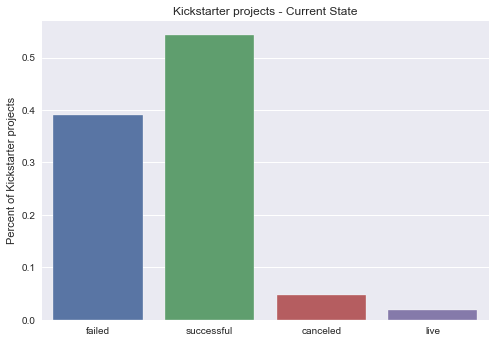

In [74]:
plt.style.use('seaborn')
sns.set_color_codes()
sns.barplot(df.state.value_counts().index,df.state.value_counts(normalize=True),
            order=['failed','successful','canceled','live'])
sns.set_palette('muted')
plt.gca().set_ylabel('Percent of Kickstarter projects')
plt.gca().set_title('Kickstarter projects - Current State');
plt.savefig('State.png')

**USD Goal vs Project Legnth**

Plot reveals that successes cluster around 30 days and below $100000

Text(0.5, 1.0, 'Days vs Monetary Goal')

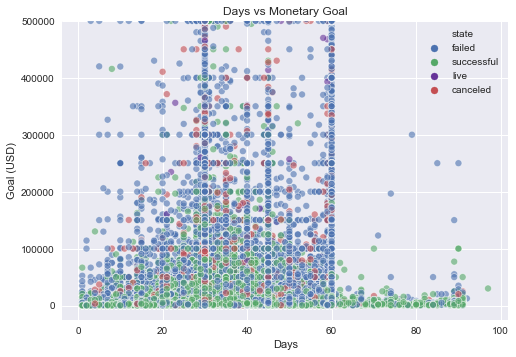

In [75]:
sns.scatterplot(df.project_length,df.usd_goal,hue=df.state.sort_values(ascending=False),
               palette=sns.color_palette(['b','g','rebeccapurple','r']),alpha=.6)

plt.gca().set_ylim((-25000,500000))
plt.ylabel('Goal (USD)')
plt.xlabel('Days')
plt.title('Days vs Monetary Goal')

**Backers vs Monetary Goal**

Plot reveals distinct decision boundary. May indicate that backers are less likely to back projects they think might not succeed becuase of a high goal. Also seems like canceled behaves similar to failed

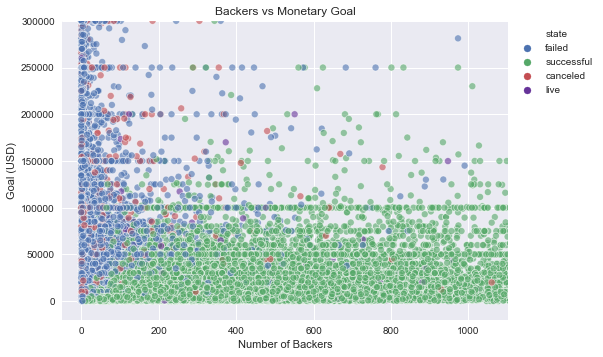

In [76]:
p = sns.color_palette(['b','g','r','rebeccapurple'])
sns.scatterplot(x='backers_count',y='usd_goal',data=df,hue='state',
                hue_order=['failed','successful','canceled','live'],palette=p,alpha=.6);
plt.xlim((-50,df.backers_count.quantile(.98)))
plt.ylim((-20000,df.usd_goal.quantile(.99)))
plt.ylabel('Goal (USD)')
plt.xlabel('Number of Backers')
plt.title('Backers vs Monetary Goal')
plt.legend(bbox_to_anchor=(1, 1),loc='upper left')
#plt.savefig('backers_vs_goal.png',bbox_inches='tight')

**Backers vs Project legnth**

Longer projects does not guarantee more backers

Text(0.5, 1.0, 'Days vs Backers')

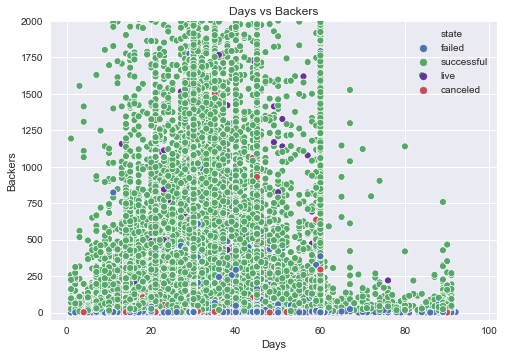

In [77]:
sns.scatterplot(df.project_length,df.backers_count,hue=df.state,
                palette=sns.color_palette(['b','g','rebeccapurple','r']))

plt.gca().set_ylim((-50,2000))
plt.ylabel('Backers')
plt.xlabel('Days')
plt.title('Days vs Backers')

**Box Plots by Project State for Numeric Values**

Further confirms that canceled projects behave similarly to failed projects and live projects are in between failure and success. Key findings from these plots:

- Blurb length doesn't really differe between classes
- Successful projects ten to have lower monetary goals (< \$25,000)
- Successful project legnth is ~ 30 days

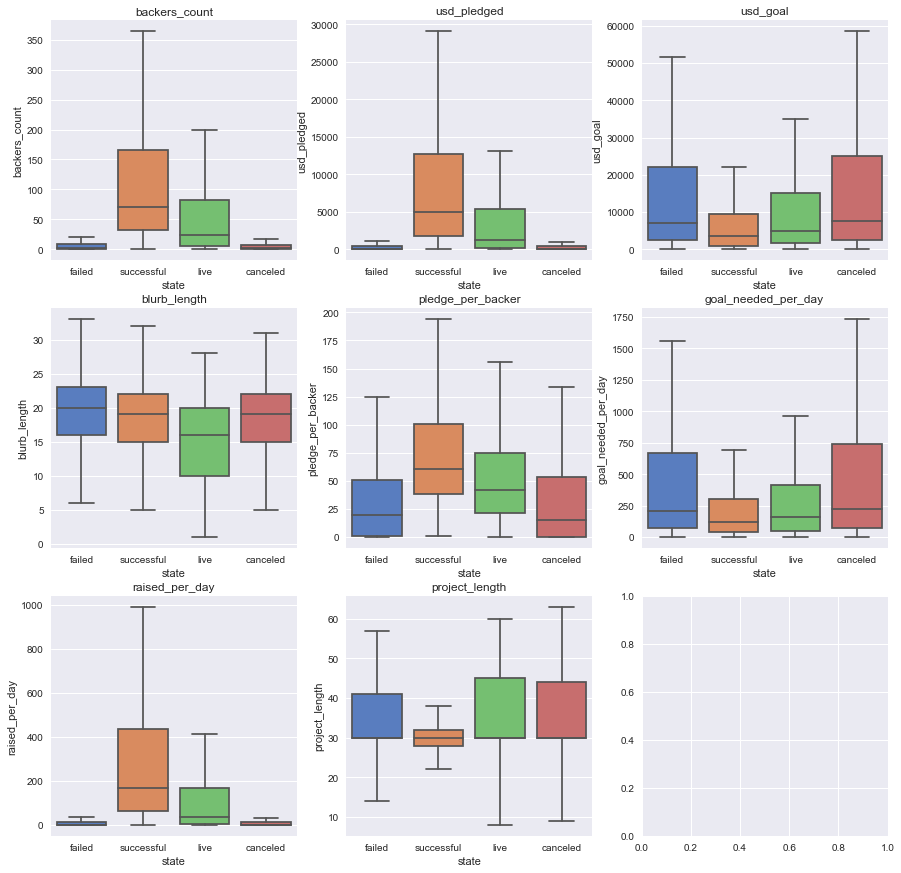

In [78]:
numeric = ['backers_count', 'usd_pledged', 
           'usd_goal', 'blurb_length','pledge_per_backer', 
           'goal_needed_per_day', 'raised_per_day','project_length']

fig, ax = plt.subplots(nrows=3,ncols=3,figsize=(15,15))

for i,col in enumerate(numeric):
    sns.boxplot(x='state',y=col,data=df,ax=ax[i//3][i%3], showfliers = False)
    ax[i//3][i%3].set_title(col)

**Staff Pick**

Projects that are selected for a staff pick succeed more often

Text(0, 0.5, 'Percent of Projects')

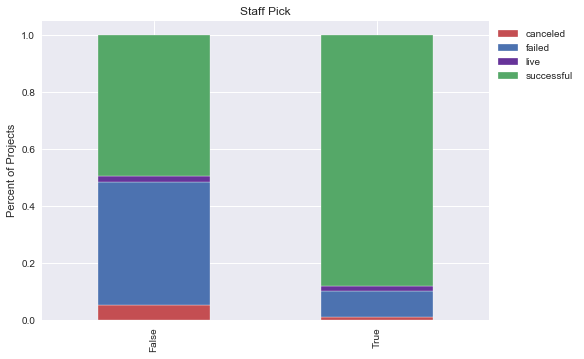

In [79]:
df.groupby(['staff_pick']).state.value_counts(normalize=True).\
            unstack().plot.bar(stacked=True, color=['r','b','rebeccapurple','g'])

plt.legend(bbox_to_anchor=(1, 1),loc='upper left')
plt.title('Staff Pick')
plt.gca().set_xlabel('')
plt.gca().set_ylabel('Percent of Projects')

**Spotlight**

Projects can only join spotlight after they are fully funded. Should not use for predicting

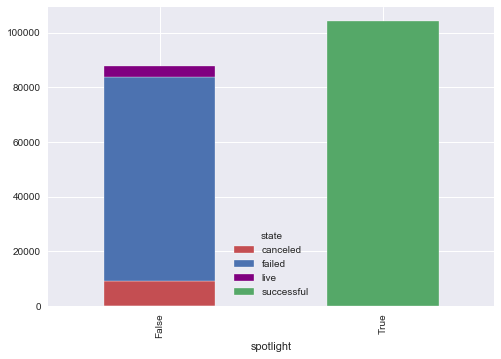

In [80]:
df.groupby(['spotlight']).state.value_counts().unstack().plot.bar(stacked=True,color=['r','b','purple','g'])

**Prior Success**

Creators who have had other successful projects are more often are successful than one-time creators.

Text(0, 0.5, 'Percent of Projects')

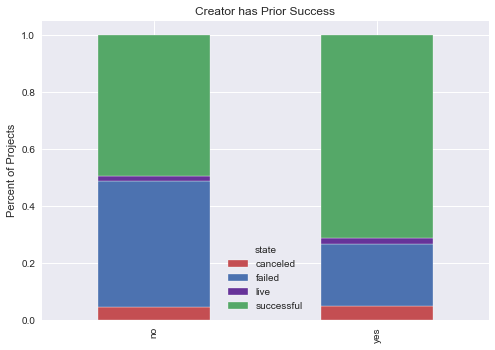

In [81]:
df.groupby(['has_prior_success']).state.value_counts(normalize=True).unstack()\
            .plot.bar(stacked=True, color=['r','b','rebeccapurple','g'])
plt.gca().set_xticklabels(['no','yes'])
plt.xlabel('')
plt.title('Creator has Prior Success')
plt.ylabel('Percent of Projects')
#plt.savefig('prior_success.png')

**Category**

Category success greatly differs, as seen by the 50 largest categories:

Text(0, 0.5, 'Percent of Projects')

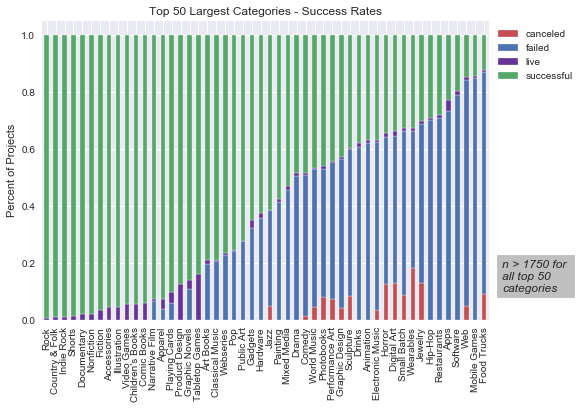

In [82]:
top_50_cat = list(df.category_name.value_counts()[:50].index)
df.loc[df.category_name.apply(lambda x: x in top_50_cat)].groupby(['category_name'])\
        .state.value_counts(normalize=True).unstack().sort_values('successful', ascending=False)\
        .plot.bar(stacked=True,color=['r','b','rebeccapurple','g'])
plt.legend(bbox_to_anchor=(1, 1),loc='upper left')
plt.title('Top 50 Largest Categories - Success Rates')
plt.xlabel('')

plt.text(51, .1, 'n > 1750 for \nall top 50\ncategories', style='italic', fontsize=12,
        bbox={'facecolor': 'grey', 'alpha': 0.5, 'pad': 5})
plt.ylabel('Percent of Projects')
#plt.savefig('category.png',bbox_inches='tight')

## Preparation for Modeling

**Dummy Columns**

Categorical columns are turned into dummy columns.

In [83]:
dummy_cols = [
    'country',
    'is_starrable',
    'spotlight',
    'staff_pick',
    'state',
    'category_name',
    'usd_type'
]
df = pd.get_dummies(df,
                    columns = dummy_cols,
                    drop_first = True)

**Live, canceled dfs**

The `live` projects are removed from the dataset and kept as a holdout, and the extra dummy columns are dropped.

In [84]:
live_df = df.loc[df.state_live == 1]
df = df.drop(df.loc[df.state_live == 1].index).drop(columns = 'state_live')
cancelled_df = df.loc[(df.state_successful == 0) & (df.state_failed == 0)]
df = df.drop(columns = 'state_failed')

**Feature elimination**

Below are features that can be eliminated from the model, either because they are already used in an engineered feature, they are not pertinent, or because they are information that wouldn't be available beforehand for a model to predict on. 

In [85]:
drop_columns = ['backers_count',
                'blurb',
                'category',
                'created_at',
                'creator',
                'deadline', 
                'launched_at',
                'location',
                'name',
                'pledged',
                'profile',
                'slug',
                'source_url',
                'state_changed_at',
                'static_usd_rate',
                'urls',
                'goal',
                'usd_pledged',
                'creator_id',
                'pledge_per_backer',
                'currency',
                'raised_per_day',
                'spotlight_True']
df = df.drop(columns = drop_columns, axis = 1)
df.reset_index(drop = True, inplace = True)

## Train Test Split

The dataframe is randomly separated into training/test data in a 80:20 split. The model will be fit on the training set, then then used to predict the target of the test set.  A random seed value is included for preproducibility.

In [86]:
data = md.tts(df)
columns = data[0].columns

# Modelling

First baseline logistic regression, random forest classifier, and xgboost models are ran with no pruning or hyperparameter tuning.  Then exhaustive search is used to find optimal hyperparameters.

## Logistic Regression

In [110]:
logreg = LogisticRegression(
    class_weight = 'balanced',
    random_state = 69, 
    solver = 'liblinear',
    C = 130,
    penalty = 'l1')
logreg = md.fitmodel(logreg, data)
md.get_scores(logreg, data)

Test F1:  0.8         Train F1: 0.806
Test Acc: 0.798         Train Acc: 0.803
Test Recall: 0.731      Train Recall: 0.736
Test Precision: 0.883   Train Precision: 0.891


In [111]:
pd.DataFrame(
    logreg.coef_[0], columns).rename(
    columns={0:'coef'}).sort_values(
    by='coef', ascending = False).head(10)

,coef
category_name_Video Games,45.749020
category_name_Tabletop Games,19.109434
category_name_Documentary,17.772714
category_name_Rock,13.072856
category_name_Product Design,12.885767
category_name_Children's Books,12.850316
category_name_Fiction,12.837397
category_name_Accessories,12.752543
category_name_Shorts,12.580161
category_name_Nonfiction,12.516303


## Random Forest

In [89]:
forest = RandomForestClassifier(
    random_state = 69,
    n_estimators = 100,
    class_weight = 'balanced',
    n_jobs = -1,
    min_samples_leaf = 5,
    min_samples_split = 10,
    max_leaf_nodes = 1000,
)
forest = md.fitmodel(forest, data)
md.ft_importance(forest, columns)

,0
staff_pick_True,0.152501
usd_goal,0.078635
goal_needed_per_day,0.073473
project_length,0.052241
has_prior_success,0.047282
category_name_Country & Folk,0.026433
category_name_Nonfiction,0.025674
category_name_Documentary,0.025209
category_name_Indie Rock,0.025201
category_name_Rock,0.024690


In [90]:
md.get_scores(forest, data)

Test F1:  0.809         Train F1: 0.823
Test Acc: 0.804         Train Acc: 0.818
Test Recall: 0.752      Train Recall: 0.765
Test Precision: 0.874   Train Precision: 0.891


In [91]:
forest

RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=1000, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=5,
                       min_samples_split=10, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=-1, oob_score=False,
                       random_state=69, verbose=0, warm_start=False)

## XG Boost

In [92]:
xgb = XGBClassifier(random_state = 69, n_jobs = -1, max_depth = 3)
xgb = md.fitmodel(xgb, data)
md.ft_importance(xgb, columns)

,0
category_name_Web,0.040698
usd_goal,0.036732
category_name_Indie Rock,0.034742
category_name_Nonfiction,0.034732
category_name_Shorts,0.033980
category_name_Country & Folk,0.033724
category_name_Rock,0.032309
category_name_Children's Books,0.032233
category_name_Apparel,0.031956
category_name_Product Design,0.031519


In [93]:
md.get_scores(xgb, data)

Test F1:  0.789         Train F1: 0.792
Test Acc: 0.779         Train Acc: 0.78
Test Recall: 0.751      Train Recall: 0.755
Test Precision: 0.832   Train Precision: 0.833


# Gridsearches

From the forest gridsearch, it was shown that it is important for this dataset to have a limit on the max leaf nodes, and have a higher min samples leaf to avoid overfitting to the training set.  F1 scoring will be used to validate the success of each model because the presence of false positives and false negatives are both relevant to the business problem. 5 folds are used to cross validate to prevent overfitting.

## Forest GS

In [94]:
# params = {
#     'n_estimators' : [100],
#     'max_features': ['auto'],
#     'criterion' : ['gini'],
# #     'max_depth' : range(2,31,2),
#     'min_samples_leaf' : [5],
#     'min_samples_split' : [6],
#     'max_leaf_nodes' : [2000],
# }
# forest = RandomForestClassifier(
#     class_weight = 'balanced',
#     random_state = 69,
#     n_jobs = -1,
# )
# forestGS = GridSearchCV(
#     estimator = forest,
#     param_grid = params,
#     cv = 5,
#     scoring = 'f1',
#     verbose = 1,
#     n_jobs = -1
# )
# forestGS.fit(data[0], data[2])
# forestGS.best_estimator_

In [ ]:
md.get_scores(forestGS.best_estimator_, data)

### L1 Log reg

The logistic regression with L1 penalty converges on an inverse regularization coefficient of 130 using the liblinear solver.  Class weights were balanced, and the data was scaled using StandardScaler so that the coefficients would be more interpretable.

In [106]:
from sklearn.preprocessing import StandardScaler
X_train = data[0]
X_test = data[1]
X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)
params = {
    'penalty' : ['l1'],
    'C' : [130],
    'class_weight' : ['balanced'],
    'solver' : ['liblinear']
}
logreg = LogisticRegression(
    max_iter = 100,
    random_state = 69)
logregGS = GridSearchCV(
    estimator = logreg,
    param_grid = params,
    cv = 5,
    n_jobs = -1,
    scoring = 'f1',
    verbose = 1,
)
logregGS.fit(X_train,data[2])
logregGS.best_estimator_

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.0min finished


LogisticRegression(C=130, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=69, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [96]:
md.get_scores(logregGS.best_estimator_, (X_train,X_test,data[2],data[3]))

Test F1:  0.801         Train F1: 0.806
Test Acc: 0.799         Train Acc: 0.803
Test Recall: 0.733      Train Recall: 0.735
Test Precision: 0.883   Train Precision: 0.891


In [97]:
ftimp = pd.DataFrame(
    logregGS.best_estimator_.coef_[0], columns).rename(
    columns={0:'coef'}).sort_values(
    by='coef', ascending = False)
ftimp.coef.apply(lambda x: abs(x))

category_name_Video Games        4.646315
category_name_Documentary        1.636871
category_name_Tabletop Games     1.632275
category_name_Rock               1.125519
category_name_Fiction            1.092657
                                  ...    
category_name_Web                0.187538
usd_type_international           0.225221
project_length                   0.282532
usd_goal                        12.720147
goal_needed_per_day             22.835767
Name: coef, Length: 192, dtype: float64

In [98]:
ftimp = pd.DataFrame(
    logregGS.best_estimator_.coef_[0], columns).rename(
    columns={0:'coef'}).sort_values(
    by='coef', ascending = False)
ind = list(ftimp.coef.apply(lambda x: abs(x)).sort_values(ascending = False).head(10).index)

In [99]:
print(ftimp.loc[ind])

                                     coef
goal_needed_per_day            -22.835767
usd_goal                       -12.720147
category_name_Video Games        4.646315
category_name_Documentary        1.636871
category_name_Tabletop Games     1.632275
category_name_Rock               1.125519
category_name_Fiction            1.092657
category_name_Children's Books   1.075237
category_name_Accessories        1.070948
category_name_Shorts             1.064961


### L2 Log reg

In [163]:
# params = {
#     'penalty' : ['l2'],
#     'C' : [120],
#     'class_weight' : ['balanced'],
#     'solver' : ['newton-cg']
# }
# logreg = LogisticRegression(
#     max_iter = 100,
#     random_state = 69)
# logregGS = GridSearchCV(
#     estimator = logreg,
#     param_grid = params,
#     cv = 2,
#     n_jobs = -1,
#     scoring = 'f1',
#     verbose = 1,
# )
# logregGS.fit(data[0],data[2])
# logregGS.best_estimator_

In [164]:
# md.get_scores(logregGS.best_estimator_, data)

# Results

In the end, all models eventually converged around an F1 around 0.8, and accuracy of ~80%.  With higher levels of depth, the xgboost and random forest were able to produce higher metrics than the logistic regression, however for the use of this project logistic is the model we choose, due to its interpretability, simplicity, and speed.

Below is the ROC curve for each of the models showing similar predictive performance.

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.891
Random Forest: ROC AUC=0.896
XGBoost: ROC AUC=0.864


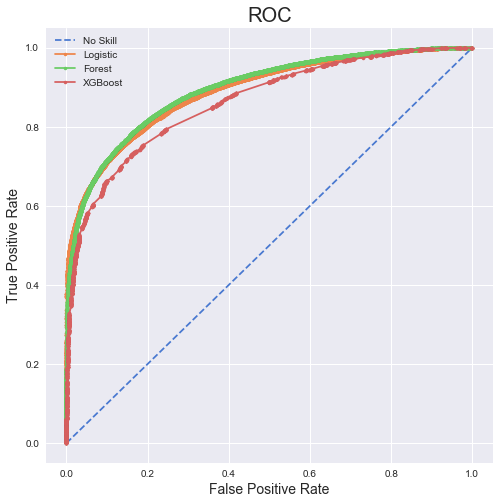

In [112]:
md.generate_ROC(data, logreg, forest, xgb, 'ROC')

## Conclusion
From the important coefficients of the logistic regression, the highest gains in log likelihood of success come from how high the goal was set, how long the project has to meet that goal, and which category the project was listed under.  Shorter projects and projects with smaller goals had a higher rate of success. Additionally, if the project was picked by staff it had a greatly improved chance of success.  Projects created by someone with prior successful projects had a higher success rate than projects created by someone without.

## Next Steps

For further project development, we would incorporate backer rewards into the model. The number of rewards available to backers, the monetary levels of those rewards and the quality of rewards may all contibriute to whether or not a backers will pledge. In addition, how success rates have varied over time may be useful information for both Kickstarter and future backers. Finally, an analysis of how our model does on other crowdfunding platforms like Indiegogo and GoFundMe, may help reveal what project do best on kickstater vs elsewhere.